In [36]:
# https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
# https://arxiv.org/pdf/1408.5882.pdf

In [37]:
import io
import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers import Input, Layer, TextVectorization, Embedding
from tensorflow.keras.layers import SeparableConv1D, Conv1D
from tensorflow.keras.layers import GlobalMaxPool1D, MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

In [38]:
DATASET = "yelp_polarity_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

DROPOUT_RATE = 0.5
DENSE_HIDDEN_UNITS = 200
BATCH_SIZE = 64
NB_CLASSES = 2
BUFFER_SIZE = 10000
NUM_ITER = 10
NUM_EPOCHS = 5

In [39]:
# # Load train dataset
# train = tfds.as_numpy(tfds.load(DATASET, data_dir=f"data/{DATASET}", split="train", batch_size=-1))
# X_train, y_train = np.array([x.decode() for x in train["text"]]), train["label"]

# # Load test dataset
# test = tfds.as_numpy(tfds.load(DATASET, data_dir=f"data/{DATASET}", split="test", batch_size=-1))
# X_test, y_test = np.array([x.decode() for x in test["text"]]), test["label"]

# print(f"Train samples: {len(X_train)}")
# print(f"Test samples:  {len(X_test)}")

In [40]:
# print(f"Label: {y_train[0]} Text: {X_train[0]}")
# print(f"Label: {y_train[5]} Text: {X_train[5]}")
# print(f"Label: {y_test[0]} Text: {X_test[0]}")
# print(f"Label: {y_test[5]} Text: {X_test[5]}")

In [41]:
# VOCAB_SIZE = 1000
# encoder = tf.keras.layers.TextVectorization(
#     max_tokens=VOCAB_SIZE)
# encoder.adapt(X_train, batch_size = BATCH_SIZE)

In [42]:
# vocab = np.array(encoder.get_vocabulary())
# vocab[:20]

In [43]:
# # Create a custom standardization function to strip HTML break tags '<br />'.
# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
#   return tf.strings.regex_replace(stripped_html,
#                                   '[%s]' % re.escape(string.punctuation), 
#                                   '')
  
# vectorize_layer = TextVectorization(
#     standardize = custom_standardization,
#     max_tokens =  VOCAB_SIZE,
#     output_mode = 'int',
#     output_sequence_length = MAX_SEQ_LENGTH)

# vectorize_layer.adapt(X_train, batch_size = BATCH_SIZE)

In [44]:
dataset, info = tfds.load(DATASET, with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Shuffling yelp_polarity_reviews-train.tfrecord...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Shuffling yelp_polarity_reviews-test.tfrecord...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/0.2.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [45]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on 

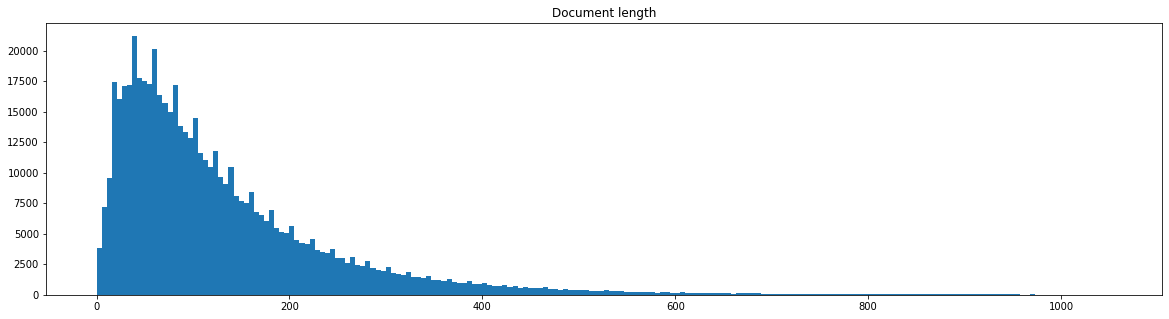

Text informations:
 - max length:   1052
 - min length:   1
 - mean length:  133.0288732142857


In [46]:
num_token = [len(str(text.numpy()).split()) for text, label in train_dataset.take(count=-1)]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(num_token, 200, density=False, range=(0,np.max(num_token)))
plt.show()

print("Text informations:")
print(f" - max length:   {np.max(num_token)}")
print(f" - min length:   {np.min(num_token)}")
print(f" - mean length:  {np.mean(num_token)}")

In [47]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH = 400
KERNEL_SIZE = [3, 4, 5]
FEATURES_MAPS = [100, 100, 100]

In [48]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [49]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"When I walked into to Herbs and Rye, it was almost pitch black. It took a minute for my eyes to adjust to the darkness. I was greeted by the hostess and walked over to the bar. I looked around and immediately was reminded of Fangtasia from True Blood.  There's an old school vibe with the brick walls, red and black wallpaper, chandeliers. and private dark leather booths. The background music was modern and made me feel like I was a vamp tramp. (Yeah, I'm a dork.) I know the theme is prohibition but I couldn't help but think of Fangtasia. Needless to say, I really dug the vibe and decor.\\n\\nMy friends and I came for happy hour. I was a little disappointed that cocktails weren't on the happy hour menu as I read about how well crafted and delicious they are. I was on a budget so I settled on a draft beer which was like $4-5 (I can't recall). \\n\\nThe best part about happy hour is the food. Unlike other restaurants where you get small bites off of the appetizer menu, here you 

In [50]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [51]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'was', 'of', 'it',
       'for', 'in', 'is', 'that', 'my', 'we', 'this', 'with', 'but',
       'they'], dtype='<U16')

In [52]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  46,    4,  345, ...,    0,    0,    0],
       [ 501,  134, 1185, ...,    0,    0,    0],
       [1479, 2534,  764, ...,    0,    0,    0]])

In [53]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"When I walked into to Herbs and Rye, it was almost pitch black. It took a minute for my eyes to adjust to the darkness. I was greeted by the hostess and walked over to the bar. I looked around and immediately was reminded of Fangtasia from True Blood.  There's an old school vibe with the brick walls, red and black wallpaper, chandeliers. and private dark leather booths. The background music was modern and made me feel like I was a vamp tramp. (Yeah, I'm a dork.) I know the theme is prohibition but I couldn't help but think of Fangtasia. Needless to say, I really dug the vibe and decor.\\n\\nMy friends and I came for happy hour. I was a little disappointed that cocktails weren't on the happy hour menu as I read about how well crafted and delicious they are. I was on a budget so I settled on a draft beer which was like $4-5 (I can't recall). \\n\\nThe best part about happy hour is the food. Unlike other restaurants where you get small bites off of the appetizer menu, here yo

In [54]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), 
                                  '')

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens =  VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = MAX_SEQ_LENGTH)

vectorize_layer.adapt(train_dataset.map(lambda text, label: text))

In [55]:
class TextCNN:
  def __init__(self, 
               vectorize_layer = None,
               kernel_sizes = [3, 4, 5],
               feature_maps = [100, 100, 100],
               dense_hidden_units = 100,
               dropout_rate = None,
               nb_classes = None):
    
    """
    Arguments:
      vocab_size : Số lượng từ tối đa trong từ điển
      embedding_dim: số chiều của vector từ
      max_seq_length: độ dài tối đa của một chuỗi từ
      kernel_sizes: mảng size của các kernel 1d trong mỗi kênh
      feature_maps: 
      dense_hidden_units:
      dropout_rate:
      nb_classes: 
    """

    self.vectorize_layer = vectorize_layer
    self.kernel_sizes = kernel_sizes
    self.feature_maps = feature_maps
    self.dense_hidden_units = dense_hidden_units
    self.dropout_rate = dropout_rate
    self.nb_classes = nb_classes  


  def create_channel(self, x, kernel_size, feature_map):

    """
    """

    # x = SeparableConv1D(
    #     filters = feature_map,
    #     kernel_size = kernel_size,
    #     depth_multiplier = 4,
    #     activation = 'relu'
    # )(x)
    x = Conv1D(
        filters = feature_map,
        kernel_size = kernel_size,
        activation = 'relu'
    )(x)
    x1 = GlobalMaxPool1D()(x)
    x2 = GlobalAveragePooling1D()(x)
    x = concatenate([x1, x2])

    # x = MaxPooling1D(pool_size=2)(x)

    # x = Dense(self.dense_hidden_units)(x)
    # if self.dropout_rate:
    #   x = Dropout(self.dropout_rate)(x)

    # return Flatten()(x)
    return x

  def create_block(self, input_layer, kernel_sizes, feature_maps):

    """
    Note .......
    """

    channels = []
    for i in range(len(kernel_sizes)):
      x = self.create_channel(input_layer, kernel_sizes[i], feature_maps[i])
      channels.append(x)

    if len(channels) > 1:
      x = concatenate(channels)

    return x


  def build_model(self):

    """

    """

    if len(self.kernel_sizes) != len(self.feature_maps):
      raise Exception("Please define 'kernel_sizes' and 'feature_maps' with the same amount.")

    if not self.nb_classes:
      raise Exception("Please define 'nb_classes'")

    if not self.vectorize_layer:
      raise Exception("Please define 'vectorize_layer'.") 

    inputs = Input(shape = (1, ), dtype = tf.string)
    word2idvec = self.vectorize_layer(inputs)
    idvec2embvec = Embedding(input_dim = VOCAB_SIZE,
                             output_dim = EMBEDDING_DIM,
                             mask_zero=True)(word2idvec)

    x = self.create_block(idvec2embvec, self.kernel_sizes, self.feature_maps)
    if self.dropout_rate:
      x = layers.Dropout(self.dropout_rate)(x)
    x = Dense(self.dense_hidden_units, activation='relu', 
              kernel_regularizer='l2')(x)
    if self.dropout_rate:
      x = layers.Dropout(self.dropout_rate)(x)
    
    if self.nb_classes == 2:
      prediction = Dense(1, activation='sigmoid')(x)
    else:
      prediction = Dense(self.nb_classes, activation='softmax')(x)

    return Model(inputs = inputs,
                 outputs = prediction)


In [56]:
# from sklearn.model_selection import train_test_split

# _X_train, _X_val, _y_train, _y_val = train_test_split(
    
# )

In [57]:
model = TextCNN(vectorize_layer = vectorize_layer,
                kernel_sizes = KERNEL_SIZE,
                feature_maps = FEATURES_MAPS,
                dense_hidden_units = DENSE_HIDDEN_UNITS,
                dropout_rate = DROPOUT_RATE,
                nb_classes = NB_CLASSES).build_model()

In [58]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [59]:
# history = model.fit(x = X_train,
#                     y = y_train, 
#                     batch_size = BATCH_SIZE,
#                     epochs=10)

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_5 (TextVecto (None, 400)          0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 100)     1000000     text_vectorization_5[0][0]       
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 398, 100)     30100       embedding_1[0][0]                
____________________________________________________________________________________________

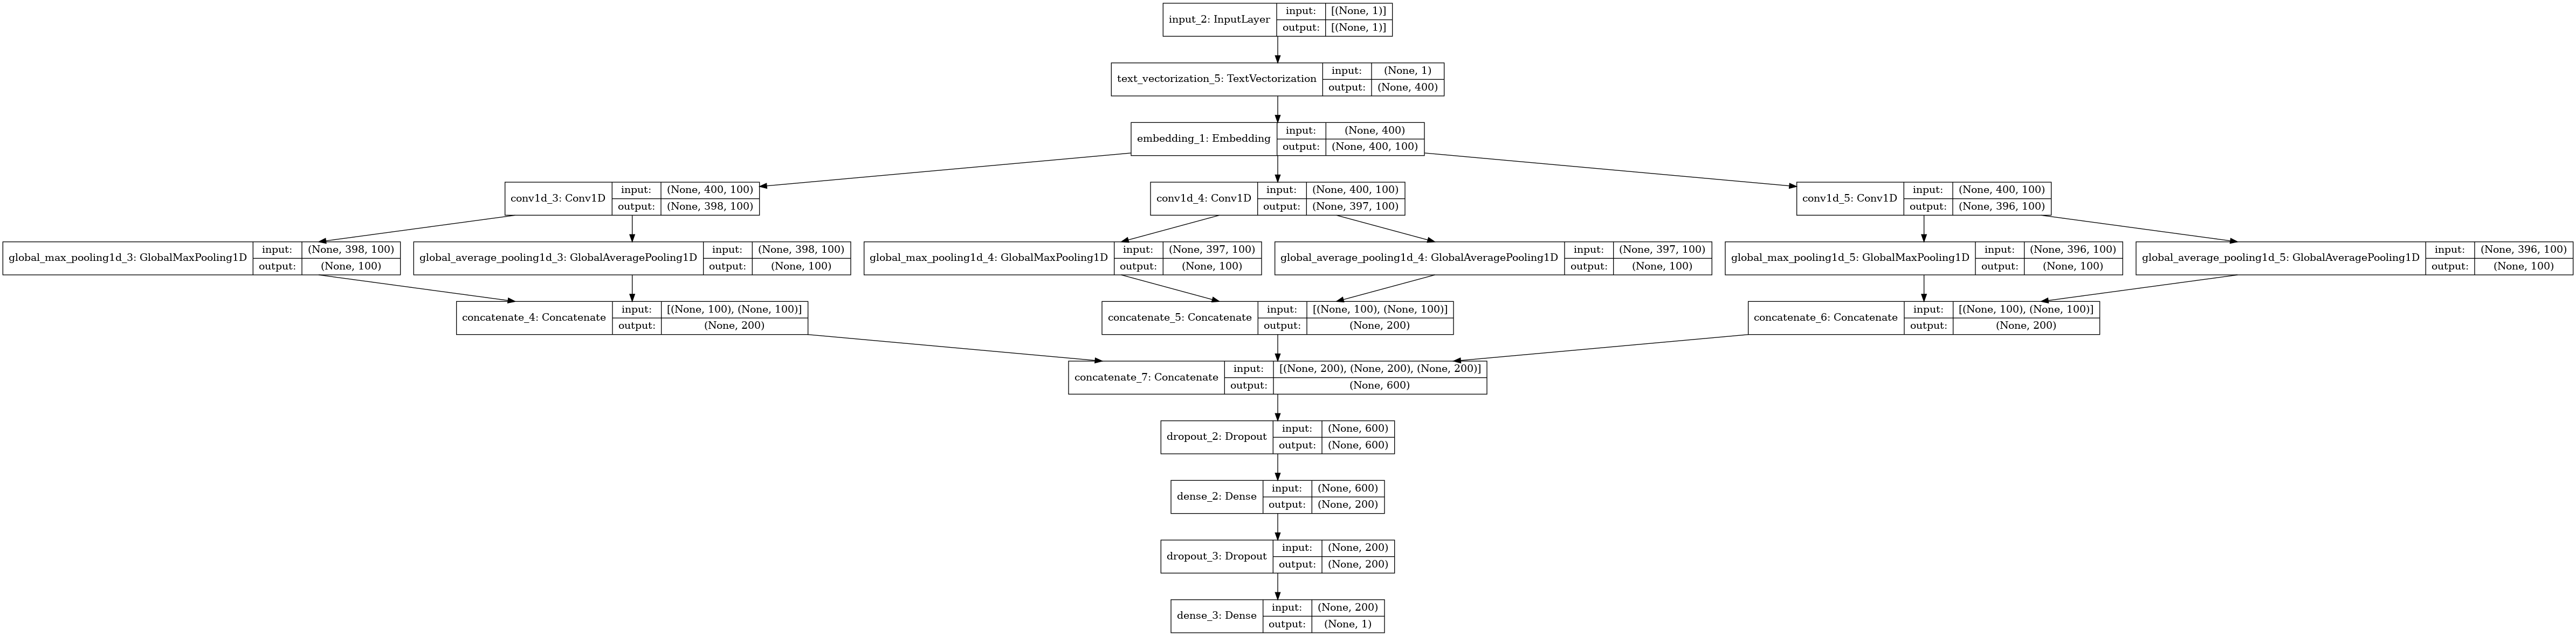

In [61]:
plot_model(model, show_shapes=True)

In [62]:
history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
8750/8750 [==============================] - 171s 19ms/step - loss: 0.3984 - accuracy: 0.8750 - val_loss: 0.1612 - val_accuracy: 0.9505
Epoch 2/5
8750/8750 [==============================] - 169s 19ms/step - loss: 0.1787 - accuracy: 0.9360 - val_loss: 0.1391 - val_accuracy: 0.9531
Epoch 3/5
8750/8750 [==============================] - 169s 19ms/step - loss: 0.1557 - accuracy: 0.9448 - val_loss: 0.1316 - val_accuracy: 0.9557
Epoch 4/5
8750/8750 [==============================] - 170s 19ms/step - loss: 0.1417 - accuracy: 0.9504 - val_loss: 0.1279 - val_accuracy: 0.9594
Epoch 5/5
8750/8750 [==============================] - 170s 19ms/step - loss: 0.1318 - accuracy: 0.9543 - val_loss: 0.1273 - val_accuracy: 0.9594


In [63]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

594/594 [==============================] - 6s 10ms/step - loss: 0.1380 - accuracy: 0.9521
Test Loss: 0.1380181461572647
Test Accuracy: 0.9521315693855286


In [64]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

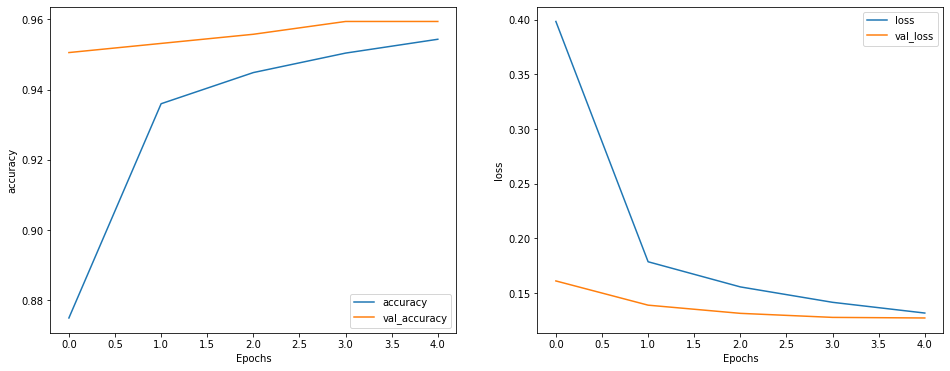

In [65]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')